## Customer Churn Prediction using Logisitic Regression, Random Forest and XGBoost

## Data Dictionary

There are multiple variables in the dataset which can be cleanly divided in 3 categories:

### Demographic information about customers

<b>customer_id</b> - Customer id

<b>vintage</b> - Vintage of the customer with the bank in number of days

<b>age</b> - Age of customer

<b>gender</b> - Gender of customer

<b>dependents</b> - Number of dependents

<b>occupation</b> - Occupation of the customer 

<b>city</b> - City of customer (anonymised)


### Customer Bank Relationship


<b>customer_nw_category</b> - Net worth of customer (3:Low 2:Medium 1:High)

<b>branch_code</b> - Branch Code for customer account

<b>days_since_last_transaction</b> - No of Days Since Last Credit in Last 1 year


### Transactional Information

<b>current_balance</b> - Balance as of today

<b>previous_month_end_balance</b> - End of Month Balance of previous month


<b>average_monthly_balance_prevQ</b> - Average monthly balances (AMB) in Previous Quarter

<b>average_monthly_balance_prevQ2</b> - Average monthly balances (AMB) in previous to previous quarter

<b>current_month_credit</b> - Total Credit Amount current month

<b>previous_month_credit</b> - Total Credit Amount previous month

<b>current_month_debit</b> - Total Debit Amount current month

<b>previous_month_debit</b> - Total Debit Amount previous month

<b>current_month_balance</b> - Average Balance of current month

<b>previous_month_balance</b> - Average Balance of previous month

<b>churn</b> - Average balance of customer falls below minimum balance in the next quarter (1/0)

## Data Loading and preprocessing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, precision_score, recall_score, precision_recall_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
df = pd.read_csv('churn_prediction.csv')

In [3]:
pd.isnull(df).sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
days_since_last_transaction       3223
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
dtype: int64

The result of this function shows that there are quite a few missing values in columns gender, dependents, city, days since last transaction and Percentage change in credits. Let us go through each of them 1 by 1 to find the appropriate missing value imputation strategy for each of them.

In [4]:
df['gender'].value_counts()

gender
Male      16548
Female    11309
Name: count, dtype: int64

So there is a good mix of males and females and arguably missing values cannot be filled with any one of them. We could create a seperate category by assigning the value -1 for all missing values in this column.

Before that, first we will convert the gender into 0/1 and then replace missing values with -1

In [5]:
#Convert Gender
dict_gender = {'Male': 1, 'Female':0}
df.replace({'gender': dict_gender}, inplace = True)

df['gender'] = df['gender'].fillna(-1)

In [6]:
df['dependents'].value_counts()

dependents
0.0     21435
2.0      2150
1.0      1395
3.0       701
4.0       179
5.0        41
6.0         8
7.0         3
9.0         1
52.0        1
36.0        1
50.0        1
8.0         1
25.0        1
32.0        1
Name: count, dtype: int64

In [7]:
df['occupation'].value_counts()

occupation
self_employed    17476
salaried          6704
student           2058
retired           2024
company             40
Name: count, dtype: int64

In [8]:
df['dependents'] = df['dependents'].fillna(0)
df['occupation'] = df['occupation'].fillna('self_employed')

In [9]:
df['city'] = df['city'].fillna(1020)

In [10]:
df['days_since_last_transaction'] = df['days_since_last_transaction'].fillna(999)

In [11]:
# Convert occupation to one hot encoded features
df = pd.concat([df,pd.get_dummies(df['occupation'],prefix = str('occupation'),prefix_sep='_')],axis = 1)

In [12]:
num_cols = ['customer_nw_category', 'current_balance',
            'previous_month_end_balance', 'average_monthly_balance_prevQ2', 'average_monthly_balance_prevQ',
            'current_month_credit','previous_month_credit', 'current_month_debit', 
            'previous_month_debit','current_month_balance', 'previous_month_balance']
for i in num_cols:
    df[i] = np.log(df[i] + 17000)

std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

In [13]:
df_df_og = df.copy()
df = df.drop(columns = num_cols,axis = 1)
df = df.merge(scaled,left_index=True,right_index=True,how = "left")

In [14]:
y_all = df.churn
df = df.drop(['churn','customer_id','occupation'],axis = 1)

## Model Building and Evaluation Metrics
Since this is a binary classification problem, we could use the following 2 popular metrics:

1. Recall
2. Area under the Receiver operating characteristic curve

Now, we are looking at the recall value here because a customer falsely marked as churn would not be as bad as a customer who was not detected as a churning customer and appropriate measures were not taken by the bank to stop him/her from churning

The ROC AUC is the area under the curve when plotting the (normalized) true positive rate (x-axis) and the false positive rate (y-axis).

Our main metric here would be Recall values, while AUC ROC Score would take care of how well predicted probabilites are able to differentiate between the 2 classes.

### Conclusions from EDA
* For debit values, we see that there is a significant difference in the distribution for churn and non churn and it might be turn out to be an important feature
* For all the balance features the lower values have much higher proportion of churning customers
* For most frequent vintage values, the churning customers are slightly higher, while for higher values of vintage, we have mostly non churning customers which is in sync with the age variable 
* We see significant difference for different occupations and certainly would be interesting to use as a feature for prediction of churn.

Now, we will first split our dataset into test and train and using the above conclusions select columns and build a baseline logistic regression model to check the ROC-AUC Score & the confusion matrix

In [15]:
baseline_cols = ['current_month_debit', 'previous_month_debit','current_balance','previous_month_end_balance','vintage'
                 ,'occupation_retired', 'occupation_salaried','occupation_self_employed', 'occupation_student']

In [16]:
df_baseline = df[baseline_cols]

### Train Test Split to create a validation set

In [17]:
# Splitting the data into Train and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(df_baseline,y_all,test_size=1/3, random_state=11, stratify = y_all)

In [18]:
model = LogisticRegression()
model.fit(xtrain,ytrain)
pred = model.predict_proba(xtest)[:,1]

### AUC ROC Curve & Confusion Matrix 

Now, let us quickly look at the AUC-ROC curve for our logistic regression model and also the confusion matrix to see where the logistic regression model is failing here.

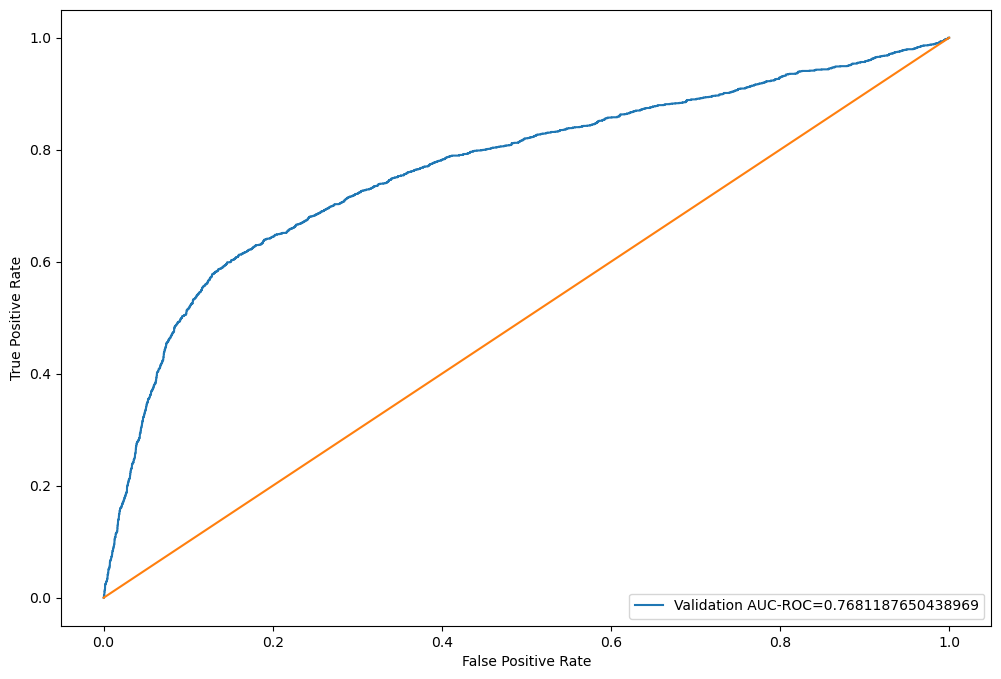

In [19]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(ytest,pred) 
auc = roc_auc_score(ytest, pred) 
plt.figure(figsize=(12,8)) 
plt.plot(fpr,tpr,label="Validation AUC-ROC="+str(auc)) 
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4) 
plt.show()

In [20]:
# Confusion Matrix
pred_val = model.predict(xtest)

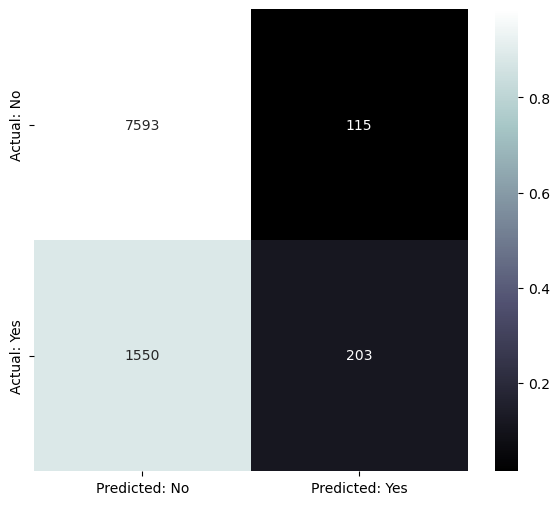

In [21]:
label_preds = pred_val

cm = confusion_matrix(ytest,label_preds)


def plot_confusion_matrix(cm, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=['Predicted: No','Predicted: Yes'], yticklabels=['Actual: No','Actual: Yes'], cmap=cmap)

plot_confusion_matrix(cm, ['No', 'Yes'])

In [22]:
# Recall Score
recall_score(ytest,pred_val)

0.11580148317170565

### Cross validation


Cross Validation is one of the most important concepts in any type of data modelling. It simply says, try to leave a sample on which you do not train the model and test the model on this sample before finalizing the model.

We divide the entire population into k equal samples. Now we train models on k-1 samples and validate on 1 sample. Then, at the second iteration we train the model with a different sample held as validation. 

In k iterations, we have basically built model on each sample and held each of them as validation. This is a way to reduce the selection bias and reduce the variance in prediction power.

Since it builds several models on different subsets of the dataset, we can be more sure of our model performance if we use CV for testing our models.

In [23]:
def cv_score(ml_model, rstate = 12, thres = 0.5, cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    # 5 Fold cross validation stratified on the basis of target
    kf = StratifiedKFold(n_splits=5,random_state=rstate,shuffle=True)
    for df_index,test_index in kf.split(df1,y_all):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[df_index],df1.loc[test_index]
        ytr,yvl = y_all.loc[df_index],y_all.loc[test_index]
            
        # Define model for fitting on the training set for each fold
        model = ml_model
        model.fit(xtr, ytr)
        pred_probs = model.predict_proba(xvl)
        pp = []
         
        # Use threshold to define the classes based on probability values
        for j in pred_probs[:,1]:
            if j>thres:
                pp.append(1)
            else:
                pp.append(0)
         
        # Calculate scores for each fold and print
        pred_val = pp
        roc_score = roc_auc_score(yvl,pred_probs[:,1])
        recall = recall_score(yvl,pred_val)
        precision = precision_score(yvl,pred_val)
        sufix = ""
        msg = ""
        msg += "ROC AUC Score: {}, Recall Score: {:.4f}, Precision Score: {:.4f} ".format(roc_score, recall,precision)
        print("{}".format(msg))
         
         # Save scores
        cv_scores.append(roc_score)
        i+=1
    return cv_scores

In [24]:
baseline_scores = cv_score(LogisticRegression(), cols = baseline_cols)


1 of kfold 5
ROC AUC Score: 0.7644836090843695, Recall Score: 0.0751, Precision Score: 0.5766 

2 of kfold 5
ROC AUC Score: 0.77848443119926, Recall Score: 0.0770, Precision Score: 0.6532 

3 of kfold 5
ROC AUC Score: 0.7551438518820636, Recall Score: 0.1359, Precision Score: 0.6441 

4 of kfold 5
ROC AUC Score: 0.758206275408844, Recall Score: 0.1169, Precision Score: 0.6508 

5 of kfold 5
ROC AUC Score: 0.7636251841935611, Recall Score: 0.1112, Precision Score: 0.5792 


Now let us try using all columns available to check if we get significant improvement.

In [25]:
all_feat_scores = cv_score(LogisticRegression())


1 of kfold 5
ROC AUC Score: 0.7331176651937108, Recall Score: 0.1103, Precision Score: 0.5088 

2 of kfold 5
ROC AUC Score: 0.7680207584009866, Recall Score: 0.1968, Precision Score: 0.6787 

3 of kfold 5
ROC AUC Score: 0.739224265528175, Recall Score: 0.1673, Precision Score: 0.5714 

4 of kfold 5
ROC AUC Score: 0.7331867870722434, Recall Score: 0.1141, Precision Score: 0.6000 

5 of kfold 5
ROC AUC Score: 0.7590890066046548, Recall Score: 0.1778, Precision Score: 0.6052 


There is some improvement in both ROC AUC Scores and Precision/Recall Scores. Now we can try backward selection to select the best subset of features which give the best score. 

### Reverse Feature Elimination or Backward Selection

We have already built a model using all the features and a separate model using some baseline features. We can try using backward feature elimination to check if we can do better. Let's do that next.

In [26]:
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# Create the RFE object and rank each feature
model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=1, step=1)
rfe.fit(df, y_all)

RFE(estimator=LogisticRegression(), n_features_to_select=1)

In [27]:
ranking_df = pd.DataFrame()
ranking_df['Feature_name'] = df.columns
ranking_df['Rank'] = rfe.ranking_

In [28]:
ranked = ranking_df.sort_values(by=['Rank'])

In [29]:
ranked

,Feature_name,Rank
13,current_balance,1
16,average_monthly_balance_prevQ,2
15,average_monthly_balance_prevQ2,3
21,current_month_balance,4
22,previous_month_balance,5
19,current_month_debit,6
8,occupation_retired,7
7,occupation_company,8
11,occupation_student,9
9,occupation_salaried,10


The balance features are proving to be very important as can be seen from the table. The RFE function can also be used to select features. Lets select the top 10 features from this table and check score.

In [30]:
rfe_top_10_scores = cv_score(LogisticRegression(), cols = ranked['Feature_name'][:10].values)


1 of kfold 5
ROC AUC Score: 0.7984815537971431, Recall Score: 0.2281, Precision Score: 0.7362 

2 of kfold 5
ROC AUC Score: 0.8050381255780497, Recall Score: 0.2234, Precision Score: 0.7581 

3 of kfold 5
ROC AUC Score: 0.7984651084768508, Recall Score: 0.2205, Precision Score: 0.7250 

4 of kfold 5
ROC AUC Score: 0.7933461309484654, Recall Score: 0.2139, Precision Score: 0.7377 

5 of kfold 5
ROC AUC Score: 0.7942658653150368, Recall Score: 0.1911, Precision Score: 0.6745 


Wow, the top 10 features obtained using the reverse feature selection are giving a much better score than any of our earlier attempts. This is the power of feature selection and it especially works well in case of linear models as tree based models are in itself to some extent capable of doing feature selection.

The recall score here is quite low. We should play around with the threshold to get a better recall score. AUC ROC depends on the predicted probabilities and is not impacted by the threshold. Let us try 0.2 as threshold which is close to the overall churn rate

In [31]:
cv_score(LogisticRegression(), cols = ranked['Feature_name'][:10].values, thres=0.14)


1 of kfold 5
ROC AUC Score: 0.7984815537971431, Recall Score: 0.8298, Precision Score: 0.2832 

2 of kfold 5
ROC AUC Score: 0.8050381255780497, Recall Score: 0.8384, Precision Score: 0.2906 

3 of kfold 5
ROC AUC Score: 0.7984651084768508, Recall Score: 0.8279, Precision Score: 0.2899 

4 of kfold 5
ROC AUC Score: 0.7933461309484654, Recall Score: 0.8213, Precision Score: 0.2842 

5 of kfold 5
ROC AUC Score: 0.7942658653150368, Recall Score: 0.8118, Precision Score: 0.2927 


[0.7984815537971431,
 0.8050381255780497,
 0.7984651084768508,
 0.7933461309484654,
 0.7942658653150368]

We observe that there is continuous improvement in the Recall Score. However, clearly precision score is going down. On the basis of business requirement the bank can take a call on deciding the threshold. Without knowing the metrics relevant to the business, our best course of action is to optimize for AUC ROC Score so as to find the best probabilites here.

## Comparison of Different model fold wise

Let us visualise the cross validation scores for each fold for the following 3 models and observe differences:
* Baseline Model
* Model based on all features
* Model based on top 10 features obtained from RFE

In [32]:
results_df = pd.DataFrame({'baseline':baseline_scores, 'all_feats': all_feat_scores, 'rfe_top_10': rfe_top_10_scores})

<Axes: >

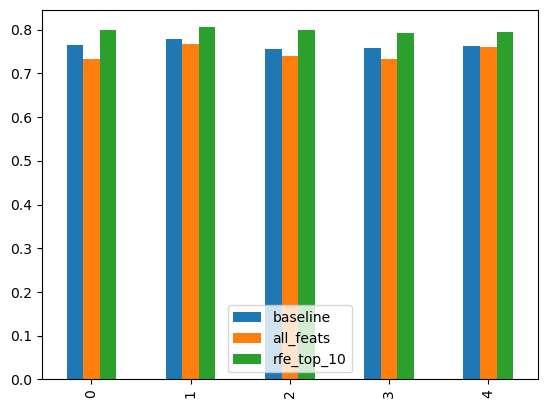

In [33]:
results_df.plot(y=["baseline", "all_feats", "rfe_top_10"], kind="bar")

## Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(xtrain, ytrain)

RandomForestClassifier(random_state=42)

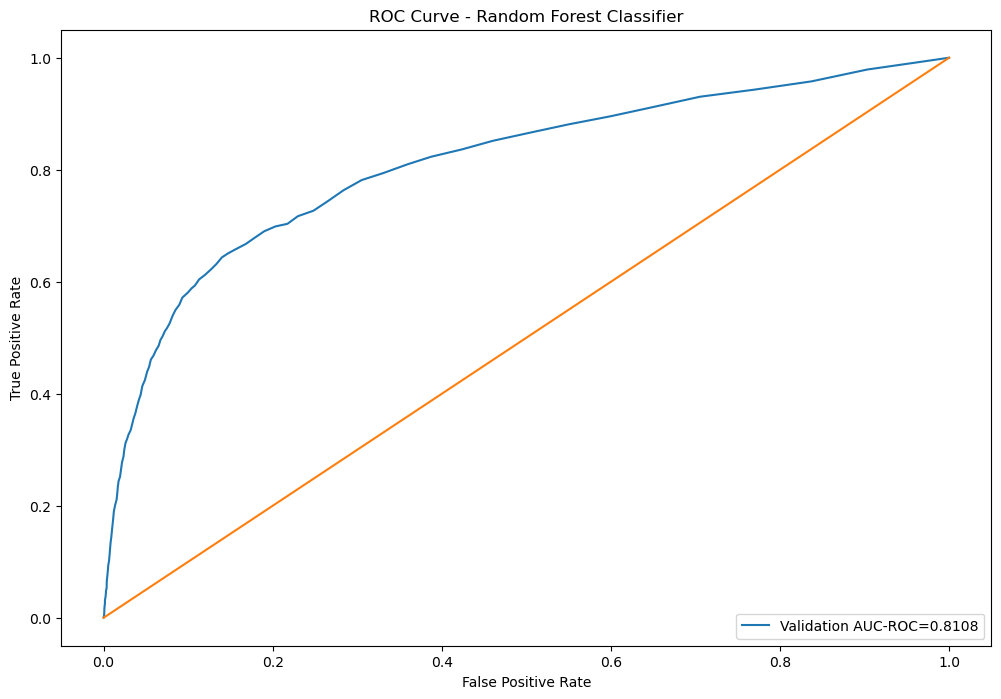

In [35]:
rf_pred_prob = rf_model.predict_proba(xtest)[:, 1]

# Compute ROC curve and AUC score
fpr_rf, tpr_rf, _ = roc_curve(ytest, rf_pred_prob)
auc_rf = roc_auc_score(ytest, rf_pred_prob)

# Plot ROC curve
plt.figure(figsize=(12, 8))
plt.plot(fpr_rf, tpr_rf, label="Validation AUC-ROC=" + str(round(auc_rf, 4)))
plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), linestyle='-')  # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.title("ROC Curve - Random Forest Classifier")
plt.show()

## XGBoost

In [36]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(xtrain.values, ytrain.values)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

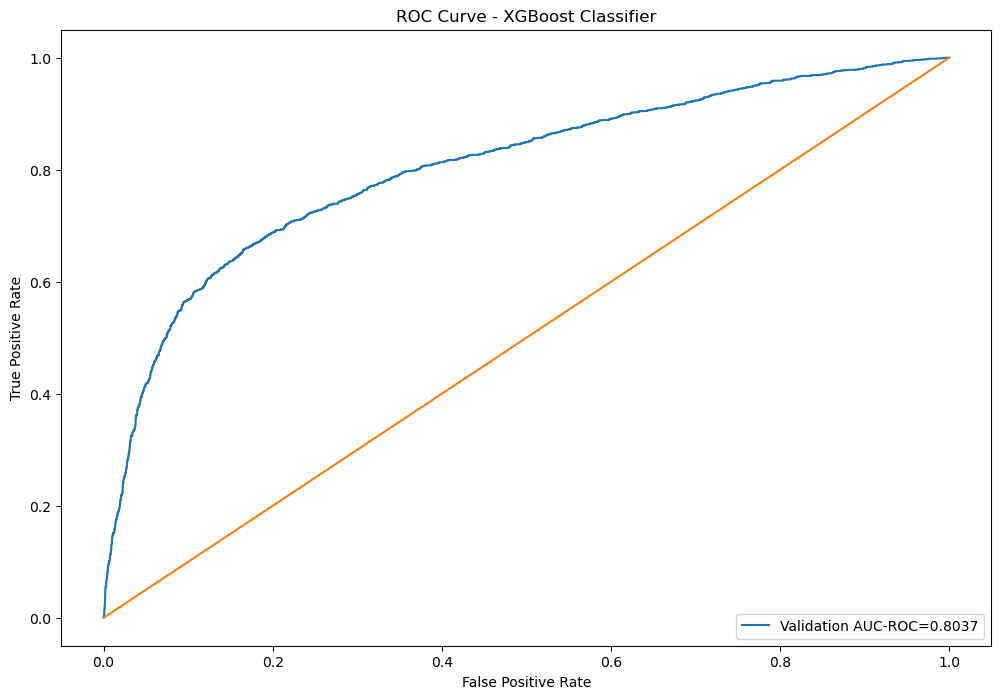

In [38]:
# Predict probabilities for the positive class
xgb_pred_prob = xgb_model.predict_proba(xtest.values)[:, 1]

# Compute ROC curve and AUC score
fpr_xgb, tpr_xgb, _ = roc_curve(ytest, xgb_pred_prob)
auc_xgb = roc_auc_score(ytest, xgb_pred_prob)

# Plot ROC curve
plt.figure(figsize=(12, 8))
plt.plot(fpr_xgb, tpr_xgb, label="Validation AUC-ROC=" + str(round(auc_xgb, 4)))
plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), linestyle='-')  # diagonal
plt.xlabel('False Positive Rate')
def cv_score(ml_model, df, y_all, rstate=12, thres=0.5, cols=None):
    if cols is None:
        cols = df.columns

    df1 = df[cols].copy()
    i = 1
    cv_scores = []

    kf = StratifiedKFold(n_splits=5, random_state=rstate, shuffle=True)

    for train_index, test_index in kf.split(df1, y_all):
        print(f'\n{i} of kfold {kf.n_splits}')
        xtr, xvl = df1.iloc[train_index], df1.iloc[test_index]
        ytr, yvl = y_all.iloc[train_index], y_all.iloc[test_index]

        # Ensure numeric types
        xtr = xtr.astype(float)
        xvl = xvl.astype(float)

        # Fit the model
        model = ml_model
        model.fit(xtr.values, ytr)

        # Predict probabilities
        pred_probs = model.predict_proba(xvl.values)
        preds = (pred_probs[:, 1] > thres).astype(int)

        # Compute metrics
        roc_score = roc_auc_score(yvl, pred_probs[:, 1])
        recall = recall_score(yvl, preds)
        precision = precision_score(yvl, preds)

        print(f"ROC AUC Score: {roc_score:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}")
        cv_scores.append(roc_score)
        i += 1

    return cv_scores

plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.title("ROC Curve - XGBoost Classifier")
plt.show()


In [39]:
def cv_score(ml_model, df, y_all, rstate=12, thres=0.5, cols=None):
    if cols is None:
        cols = df.columns

    df1 = df[cols].copy()
    i = 1
    cv_scores = []

    kf = StratifiedKFold(n_splits=5, random_state=rstate, shuffle=True)

    for train_index, test_index in kf.split(df1, y_all):
        print(f'\n{i} of kfold {kf.n_splits}')
        xtr, xvl = df1.iloc[train_index], df1.iloc[test_index]
        ytr, yvl = y_all.iloc[train_index], y_all.iloc[test_index]

        # Ensure numeric types
        xtr = xtr.astype(float)
        xvl = xvl.astype(float)

        # Fit the model
        model = ml_model
        model.fit(xtr.values, ytr)

        # Predict probabilities
        pred_probs = model.predict_proba(xvl.values)
        preds = (pred_probs[:, 1] > thres).astype(int)

        # Compute metrics
        roc_score = roc_auc_score(yvl, pred_probs[:, 1])
        recall = recall_score(yvl, preds)
        precision = precision_score(yvl, preds)

        print(f"ROC AUC Score: {roc_score:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}")
        cv_scores.append(roc_score)
        i += 1

    return cv_scores


In [40]:
cv_score(rf_model, df, y_all)


1 of kfold 5
ROC AUC Score: 0.8286, Recall: 0.4211, Precision: 0.6976

2 of kfold 5
ROC AUC Score: 0.8467, Recall: 0.4477, Precision: 0.7634

3 of kfold 5
ROC AUC Score: 0.8425, Recall: 0.4401, Precision: 0.7468

4 of kfold 5
ROC AUC Score: 0.8348, Recall: 0.4363, Precision: 0.7251

5 of kfold 5
ROC AUC Score: 0.8285, Recall: 0.4468, Precision: 0.7132


[0.8285746583084986,
 0.8467279827355874,
 0.8425165609746471,
 0.8347514455905376,
 0.828524325884458]

In [41]:
cv_score(xgb_model, df, y_all)


1 of kfold 5
ROC AUC Score: 0.8189, Recall: 0.4629, Precision: 0.6644

2 of kfold 5
ROC AUC Score: 0.8266, Recall: 0.4743, Precision: 0.7149

3 of kfold 5
ROC AUC Score: 0.8156, Recall: 0.4686, Precision: 0.6895

4 of kfold 5
ROC AUC Score: 0.8214, Recall: 0.4677, Precision: 0.6491

5 of kfold 5
ROC AUC Score: 0.8156, Recall: 0.4724, Precision: 0.6680


[0.8188636316925291,
 0.8265995272839379,
 0.8155564619048246,
 0.8213656513544805,
 0.8156237871182916]

In [43]:
rf = RandomForestClassifier(random_state=42)
rf.fit(df, y_all)

# Get feature importances and top 10 features
rf_importances = pd.DataFrame({
    'Feature_name': df.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Top 10 feature names
top10_rf_features = rf_importances['Feature_name'].iloc[:10].values

# CV score for top 10 RF features
cv_score(RandomForestClassifier(random_state=42), df=df, y_all=y_all, cols=top10_rf_features, thres=0.14)



1 of kfold 5
ROC AUC Score: 0.8258, Recall: 0.7899, Precision: 0.3735

2 of kfold 5
ROC AUC Score: 0.8377, Recall: 0.8061, Precision: 0.3801

3 of kfold 5
ROC AUC Score: 0.8419, Recall: 0.8118, Precision: 0.4021

4 of kfold 5
ROC AUC Score: 0.8369, Recall: 0.8137, Precision: 0.3759

5 of kfold 5
ROC AUC Score: 0.8323, Recall: 0.7899, Precision: 0.3786


[0.8258476004521631,
 0.8376763950262048,
 0.8419157733827146,
 0.83685230061047,
 0.8322975186495981]

In [44]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(df, y_all)

# Get feature importances and top 10 features
xgb_importances = pd.DataFrame({
    'Feature_name': df.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Top 10 feature names
top10_xgb_features = xgb_importances['Feature_name'].iloc[:10].values

# CV score for top 10 XGBoost features
cv_score(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), df=df, y_all=y_all, cols=top10_xgb_features, thres=0.14)



1 of kfold 5
ROC AUC Score: 0.8185, Recall: 0.7310, Precision: 0.4417

2 of kfold 5
ROC AUC Score: 0.8268, Recall: 0.7367, Precision: 0.4553

3 of kfold 5
ROC AUC Score: 0.8189, Recall: 0.7129, Precision: 0.4596

4 of kfold 5
ROC AUC Score: 0.8230, Recall: 0.7338, Precision: 0.4386

5 of kfold 5
ROC AUC Score: 0.8126, Recall: 0.7148, Precision: 0.4370


[0.8184760045216319,
 0.826789949645463,
 0.8189164525964714,
 0.8229784756667149,
 0.8126410231952319]

## So, we can conclude that Random Forest performs better when the top 10 features are considered